# ResNet34

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os

from torch.utils.data import DataLoader
from data.image_dataset import ImageDataset
from torchvision.transforms import v2
from torchvision.models import resnet34
from models.convnet import ConvNet
from models.nvgaze import NVGaze
from models.incep_convnet import IncepConvNet
from training.train import *
from training.eval import *
from data.convert_labels import *
from utils.dataset_utils import check_disjoint
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
subject = '01'
stride = 20
num_channels = 3
input_dims = (224, 224)
note = ''
mode = 'reg'
batch_size = 32

In [12]:
data_subset = f'{subject}_{stride:>02}_{input_dims[0]}_{input_dims[1]}{f'_{note}' if note else ''}'
train_dir_path = f'data/real/{data_subset}/train'
train_annotations_file_path = f'{train_dir_path}/{data_subset}_train.csv'
val_dir_path = f'data/real/{data_subset}/val'
val_annotations_file_path = f'{val_dir_path}/{data_subset}_val.csv'
test_dir_path = f'data/real/{data_subset}/test'
test_annotations_file_path = f'{test_dir_path}/{data_subset}_test.csv'

# def transform(img):
#   img_inv = 255 - img
#   img_inv_thresh = F.threshold(img_inv, 140, 0)
#   out = torch.cat([img, img_inv_thresh], dim=0)
#   return out

transform = lambda img: img.repeat(3, 1, 1)

# augmentation = v2.Compose([
#     v2.GaussianNoise(sigma=0.01),
#     v2.ColorJitter(brightness=0.1)
# ])

target_transform = None if mode == 'reg' else (lambda target: convert_labels(target))

train_dataset = ImageDataset(
  annotations_file=train_annotations_file_path,
  img_dir=train_dir_path,
  transform=transform,
  target_transform=target_transform
)
val_dataset = ImageDataset(
  annotations_file=val_annotations_file_path,
  img_dir=val_dir_path,
  transform=transform,
  target_transform=target_transform
)
test_dataset = ImageDataset(
  annotations_file=test_annotations_file_path,
  img_dir=test_dir_path,
  transform=transform,
  target_transform=target_transform
)

# assert(check_disjoint(val_dataset, test_dataset))

Feature batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32, 2])


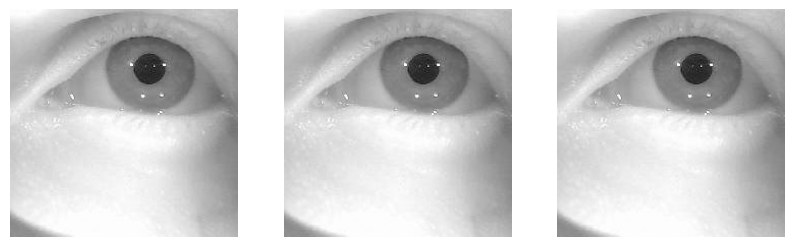

In [13]:
# Create Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")

for i in range(num_channels):
  plt.subplot(1, num_channels, i + 1)
  plt.gca().axis('off')
  plt.imshow(train_features[0, i].squeeze().numpy())
plt.show()

In [14]:
out_num_features = 2 if mode == 'reg' else 16

# model = ConvNet(input_dims)
# model = NVGaze(input_dims, out_num_features, dropout_param=0.005)
# model = IncepConvNet(input_dims, out_num_features)
model = resnet34(num_classes=2)

criterion = nn.MSELoss() if mode == 'reg' else nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.99, weight_decay=0.1, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set-up GPU device (if available) and move model
device = torch.device('mps' if torch.mps.is_available else 'cpu')
model = model.to(device)
print(f'Using device: {device}')

results = train(model, device, mode, criterion, optimizer, train_loader, val_loader, epochs=100)

Using device: mps
| Epoch   1 | Train err 0.674980 (38.67°) | Val err 0.592616 (33.95°) |
| Epoch   2 | Train err 0.144655 (8.29°) | Val err 0.178319 (10.22°) |
| Epoch   3 | Train err 0.145179 (8.32°) | Val err 0.165653 (9.49°) |
| Epoch   4 | Train err 0.112853 (6.47°) | Val err 0.146230 (8.38°) |
| Epoch   5 | Train err 0.101463 (5.81°) | Val err 0.118745 (6.80°) |
| Epoch   6 | Train err 0.067650 (3.88°) | Val err 0.102809 (5.89°) |
| Epoch   7 | Train err 0.102817 (5.89°) | Val err 0.088649 (5.08°) |
| Epoch   8 | Train err 0.065181 (3.73°) | Val err 0.093156 (5.34°) |
| Epoch   9 | Train err 0.059199 (3.39°) | Val err 0.098409 (5.64°) |
| Epoch  10 | Train err 0.053019 (3.04°) | Val err 0.087302 (5.00°) |
| Epoch  11 | Train err 0.054124 (3.10°) | Val err 0.094007 (5.39°) |
| Epoch  12 | Train err 0.033147 (1.90°) | Val err 0.071235 (4.08°) |
| Epoch  13 | Train err 0.065366 (3.75°) | Val err 0.090725 (5.20°) |
| Epoch  14 | Train err nan (nan°) | Val err 0.077474 (4.44°) |
| Epo

In [ ]:
# Additional training
optimizer = optim.Adam(model.parameters(), lr=1e-4)

results = train(model, device, mode, criterion, optimizer, train_loader, val_loader, epochs=10)

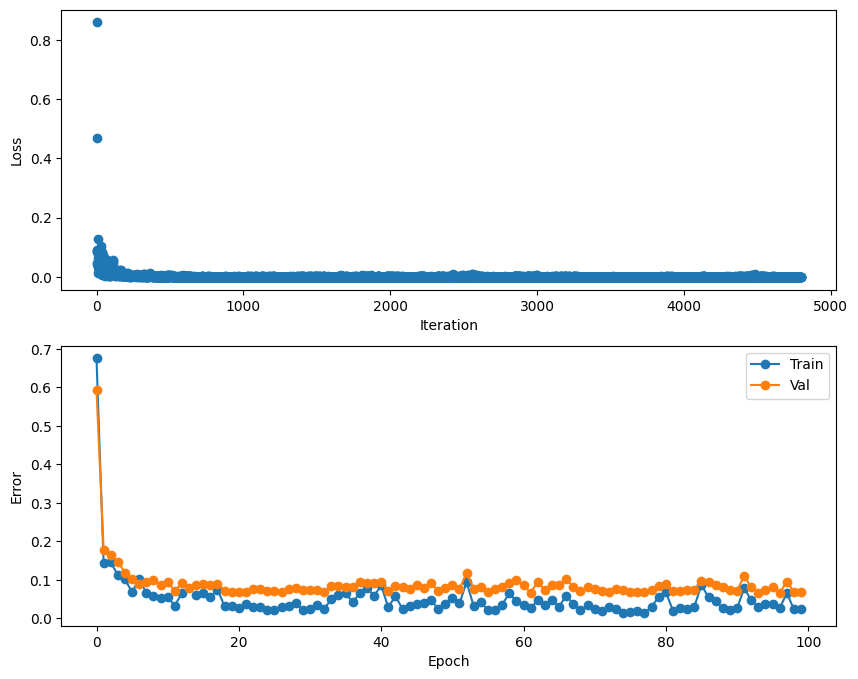

In [15]:
loss_history, train_perf_history, val_perf_history = results
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_perf_history, '-o')
plt.plot(val_perf_history, '-o')
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Error' if mode == 'reg' else 'Accuracy')

fig = plt.gcf()
plt.show()

In [16]:
if mode == 'reg':
  train_error = evaluate_error(model, device, train_loader)
  val_error = evaluate_error(model, device, val_loader)
  test_error = evaluate_error(model, device, test_loader)
  train_error_str = f'Train err: {train_error.item():.6f} ({np.rad2deg(train_error.item()):.2f}°)'
  val_error_str = f'Val err:   {val_error.item():.6f} ({np.rad2deg(val_error.item()):.2f}°)'
  test_error_str = f'Test err:  {test_error.item():.6f} ({np.rad2deg(test_error.item()):.2f}°)'
  error_summary = [train_error_str, val_error_str, test_error_str]
  error_summary_str = '\n'.join(error_summary)
  print(error_summary_str)
else:
  test_acc = evaluate_acc(model, device, test_loader)
  print(f'Test acc: {test_acc.item()}')

Train err: 0.024127 (1.38°)
Val err:   0.067909 (3.89°)
Test err:  0.100821 (5.78°)


In [ ]:
# Save current model
s = datetime.fromtimestamp(time.time()).strftime('%m-%d--%H-%M-%S')
dir_path = f'models/saved_models/{s}'

os.mkdir(dir_path)
with open(f'{dir_path}/{s}.txt', 'w') as f:
  f.write(error_summary_str)
  f.write('\n\n')
  for i, (train_err, val_err) in enumerate(zip(train_perf_history, val_perf_history)):
    train_err_deg = torch.rad2deg(train_err)
    val_err_deg = torch.rad2deg(val_err)
    f.write(f'| Epoch {i + 1:3d} | Train err {train_err:.6f} ({train_err_deg:.2f}°) | Val err {val_err:.6f} ({val_err_deg:.2f}°) |\n')
fig.savefig(f'{dir_path}/{s}.png')
torch.save(model.state_dict(), f'{dir_path}/{s}.pt')